In [1]:
# Studying a piece of land and analyzing the geography for use with irrigation

# Add the Python ArcGIS package to the default Anaconda packages that were installed during Navigator install
# !pip install arcgis

In [15]:
import arcgis
from arcgis.gis import GIS
from arcgis.raster.functions import *
from ipywidgets import *

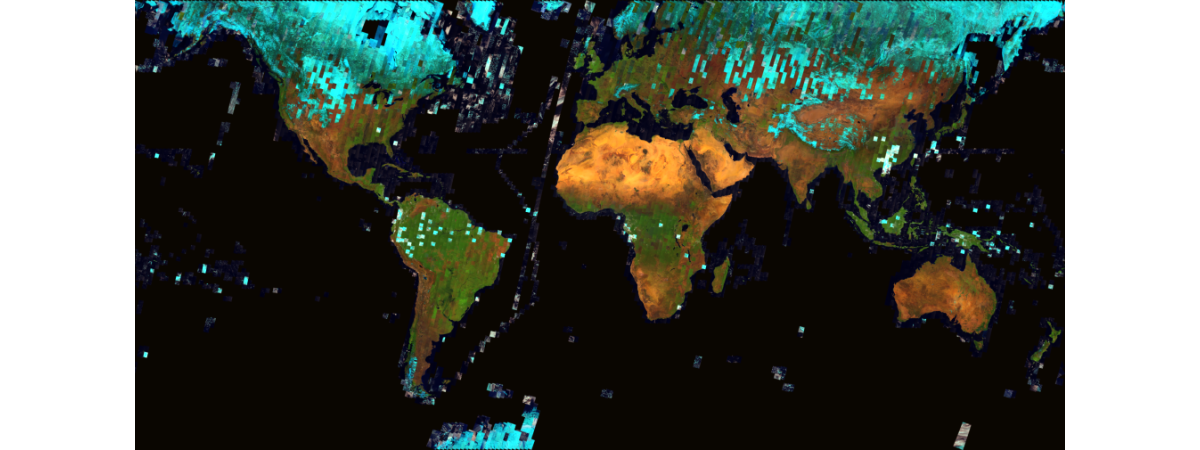

In [2]:
gis = GIS()

arcgis.raster.analytics.is_supported(gis)

search_item = gis.content.search('title:Multispectral Landsat', 'Imagery Layer', outside_org=True)[0]
landsat = search_item.layers[0]

landsat

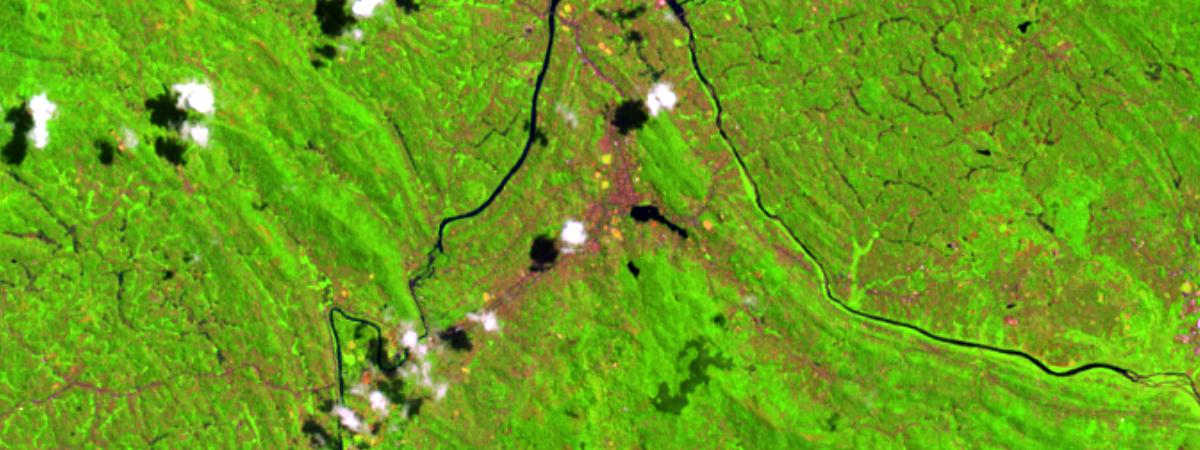

In [16]:
# Access ArcGIS online tools to get a satellite image of the Bangalore region

from arcgis.geocoding import geocode

extent = geocode("Kandi", "India", out_sr=landsat.properties.spatialReference)[1]
landsat.extent = extent['extent']
landsat

In [17]:
# Use the GMRT online mapping tool to get terrain for an area east of Bangalore
# https://www.gmrt.org/GMRTMapTool/

# Bangalore is centered at: [12.971599, 77.594566]
# So use bounds of [12.99, 77.59] and [13.01, 77.57]

# Save the terrain grid as ArcASCII File Format, and High Grid Resolution
# It downloads an .asc file with 39 columns and 35 rows

# Read in the terrain to a two-dimensional array:

import numpy as np

Terrain  = np.loadtxt("kandiactual.asc", skiprows=6)
print(Terrain[1][12])

713.85


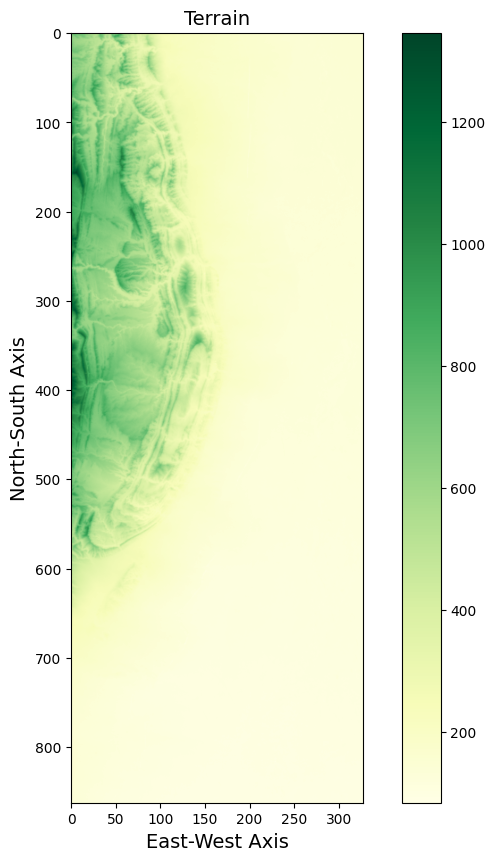

In [5]:
#Plot the terrain to see it visually

import matplotlib.pyplot as plt
from PIL import Image  #images processing package

def plot_terrain():
    #plot vegetation cover
    plt.figure(figsize=(10, 10))
    plt.imshow(Terrain)

    plt.xlabel('East-West Axis', fontsize=14)
    plt.ylabel('North-South Axis', fontsize=14)
    plt.title('Terrain', fontsize=14);
    plt.set_cmap("YlGn")
    plt.colorbar()
    
    plt.show()
        
plot_terrain()

In [18]:
# Set a uniform soil depth at all locations

nx = len(Terrain[0])
ny = len(Terrain)

# create soil data array
Soil = np.zeros([ny, nx], dtype = float)

def fill_soil_grid():
    #fill the Soil grid
    for i in range(0, nx): #march east to west
        for j in range(0, ny): #march south to north
            Soil[j][i] = 30

fill_soil_grid()

print (Soil)

[[30. 30. 30. ... 30. 30. 30.]
 [30. 30. 30. ... 30. 30. 30.]
 [30. 30. 30. ... 30. 30. 30.]
 ...
 [30. 30. 30. ... 30. 30. 30.]
 [30. 30. 30. ... 30. 30. 30.]
 [30. 30. 30. ... 30. 30. 30.]]


In [19]:
# Set a uniform water table depth at all locations

nx = len(Terrain[0])
ny = len(Terrain)

# create soil data array
Winit = np.zeros([ny, nx], dtype = float)

def fill_water_table_grid():
    #fill the Water grid
    for i in range(0, nx): #march east to west
        for j in range(0, ny): #march south to north
            Winit[j][i] = 2

fill_water_table_grid()

print (Winit)

[[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]]


In [20]:
# Set a uniform vegetation amount at all locations (consider changing that over a season)

nx = len(Terrain[0])
ny = len(Terrain)

# create soil data array
Vegetation = np.zeros([ny, nx], dtype = float)

def fill_vegetation_grid():
    #fill the Vegetation grid
    for i in range(0, nx): #march east to west
        for j in range(0, ny): #march south to north
            #0 is completely vegetated, 255 is no plant life (valid range is 0-255)
            Vegetation[j][i] = 100

fill_vegetation_grid()

print (Vegetation)

[[100. 100. 100. ... 100. 100. 100.]
 [100. 100. 100. ... 100. 100. 100.]
 [100. 100. 100. ... 100. 100. 100.]
 ...
 [100. 100. 100. ... 100. 100. 100.]
 [100. 100. 100. ... 100. 100. 100.]
 [100. 100. 100. ... 100. 100. 100.]]


In [21]:
#Calculate the water surface flow

import numpy as np

def calculate_flow(dem):
    rows, cols = dem.shape
    flow_direction = np.zeros((rows, cols), dtype=int)
    flow_slope = np.zeros((rows, cols), dtype=float)
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            max_slope = 0
            direction = 0
            current_elevation = dem[i, j]
            for di, dj, d in [(-1, 0, 1), (1, 0, 1), (0, -1, 1), (0, 1, 1), (-1, -1, np.sqrt(2)), (-1, 1, np.sqrt(2)), (1, -1, np.sqrt(2)), (1, 1, np.sqrt(2))]:
                neighbor_elevation = dem[i + di, j + dj]
                slope = (current_elevation - neighbor_elevation) / d
                if slope > max_slope:
                    max_slope = slope
                    direction = (di + 1) * 3 + (dj + 1)
            flow_direction[i, j] = direction
            flow_slope[i, j] = max_slope
    return [flow_direction, flow_slope]

# Example DEM
dem = Terrain

result = calculate_flow(dem)
flow_direction = result[0]
slope = result[1]

print(slope[3][3])

23.770000000000095


In [23]:
min_temp = 30  # Minimum temperature in Celsius
max_temp = 35  # Maximum temperature in Celsius

# Example constant temperature in Celsius
actual_temperature = np.ones((ny, nx)) * 32  # Example constant temperature of 25°C

# Normalize the temperature between 0 and 1
normalized_temperature = (actual_temperature - min_temp) / (max_temp - min_temp)

def calculate_evapotranspiration(vegetation, temperature):
    # Example function: evapotranspiration rate increases with temperature and decreases with vegetation density
    # Vegetation and temperature are assumed to be normalized between 0 and 1
    base_et = 0.5  # base evapotranspiration rate
    et = base_et * (1 - vegetation / 255) * temperature
    return et

In [24]:
# Run a hydrology model that drives water movement
# See tutorials at https://www.hec.usace.army.mil/confluence/hmsdocs/hmsguides

import numpy as np     #numeric processing package
import math as math    #mathematics functions package
import random

river_flow = 2.855e10 # cm^3/second  #flow of river at start

#Define the Parameters (lengths all in cm)
L=390000;  # length of estuary in cm (3.9 kilometers) East-West Distance
h=350000;  # width of estuary in cm (3.5 kilometers)  North-South Distance
dx=10000;  # E-W grid spacing in cm (100 meters) East-West Spacing
dy=10000;  # N-S grid spacing in cm (100 meters) North-South Spacing

#Factors controlling water diffusion
Kh=2.895e-5; # TO RESEARCH: horizontal diffusivity (2.895 x 10^-5 cm^2/s)
Kv=2.895e-5; # TO RESEARCH: vertical diffusivity   (2.895 x 10^-5 cm^2/s)

ntimes=7*24+1; # number of time steps (seven days)
dt=3600;       # time per time step (one hour)

# using kandi hydro proj.pdf for guidance...

# create precipitation data array
Precip = np.zeros([ny, nx], dtype = float)

def fill_precipitation_grid():
    #fill the Precipitation grid
    for i in range(0, nx): #march east to west
        for j in range(0, ny): #march south to north
            #0 is completely vegetated, 255 is no plant life (valid range is 0-255)
            Precip[j][i] = (5 + random.random()*(2))/(31*24) # annual amount of rain

fill_precipitation_grid()

def calculate_growth_rate(water_table, precipitation, water_coefficient, precip_coefficient):
    growth_rate = (water_table.mean() * water_coefficient) + (precipitation.mean() * precip_coefficient)
    return growth_rate

print (Precip)





W = np.zeros([ny,nx,ntimes])
W[:,:,0] = Winit

F = []
P = []
p_rand = 0

# For future use:
river_y = [113,113,113,113,114,115,115,116,116,117,118,118,118,119,119,119,119,120,120,120,120,120,119,119,119,120,120,121,122,122,123,123,124,125,124,125,125,126,126,127,127,128,128,127,127,126,127,126,126,125,126]
river_x = [0,1,2,3,3,3,4,4,5,5,5,6,7,7,8,9,10,10,11,12,12,13,13,14,15,15,16,16,16,17,17,18,19,20,20,21,22,22,23,23,24,24,25,25,26,27,27,28,29,30,30]

import matplotlib.pyplot as plt
from matplotlib import cm

# create a function for water diffusion:
def water_diffusion(k, i, j):
    result = W[i,j,k-1] + Kh*(dt/dx**2)*(W[i,j+1,k-1]-2*W[i,j,k-1]+W[i,j-1,k-1])
    result = result + Kv*(dt/dy**2)*(W[i+1,j,k-1]-2*W[i,j,k-1]+W[i-1,j,k-1])
    return result

#things we could add to the hydrology model:

# Depth of the Soil
# Depth of the roots of plant life
# Porocity of the soil
# Air temperature (the rate of evaporation, and how much water the air can hold)
# Type of canopy

for t in range(1, ntimes):
    for i in range(1, ny-1):  # march east to west
        for j in range(1, nx-1):  # march south to north
            W[i][j][t] = water_diffusion(t, i, j)  # process water diffusion
            
            # Process evapotranspiration
            et = calculate_evapotranspiration(Vegetation[i][j], normalized_temperature[i][j])
            W[i][j][t] -= et  # Subtract evapotranspiration from water table
            
            # Process water evaporation and respiration as before
            if W[i][j][t] < Soil[i][j]:
                W[i][j][t] -= 0.00001 * (255 - Vegetation[i][j])  # if absorbing in soil
            else:
                W[i][j][t] -= 0.0005 * (255 - Vegetation[i][j])  # if saturated

            if W[i][j][t] < 0:  # no negative water values allowed
                W[i][j][t] = 0
            
            W[i][j][t] += 0.00007 * Vegetation[i][j]  # process respiration
            
            if random.random() < 0.10:  # 10% chance of rain per timestep
                p_rand = random.random() * 200 + 10  # amount of rain divisor if rained
                W[i][j][t] += Precip[i][j] / p_rand  # process precipitation

            # Check indices before printing and calculations
            if j < 10 and i > 20:
                if j < Vegetation.shape[0] and i < Vegetation.shape[1]:
                    #print("Start Maize: ", Vegetation[j][i])
                    gr = calculate_growth_rate(W[i][j][t], Precip[i][j], .0005, .0002)
                    Vegetation[j][i] = Vegetation[j][i] - Vegetation[j][i]*(gr)
                    if j == 1 and i == 21:
                        print("End Maize: ", Vegetation[j][i])

            # Check indices before printing and calculations
            if j > 20 and i < 10:
                if j < Vegetation.shape[0] and i < Vegetation.shape[1]:
                    #print("Start Black Gram: ", Vegetation[j][i])
                    gr = calculate_growth_rate(W[i][j][t], Precip[i][j], .0002, .0001)
                    Vegetation[j][i] = Vegetation[j][i] - Vegetation[j][i]*(gr)
                    if j == 21 and i == 1:
                        print("Black Gram: ", Vegetation[j][i])

            #process the surface flow
            if(flow_direction[i][j]==1 and W[i-1][j][t] > Soil[i-1][j]):
                W[i][j][t] = W[i][j][t] + (W[i-1][j][t] - Soil[i-1][j]) * slope[i][j] * 0.000001
            elif(flow_direction[i][j]==2 and W[i+1][j][t] > Soil[i+1][j]):
                W[i][j][t] = W[i][j][t] + (W[i+1][j][t] - Soil[i+1][j]) * slope[i][j] * 0.000001
            elif(flow_direction[i][j]==3 and W[i][j-1][t] > Soil[i][j-1]):
                W[i][j][t] = W[i][j][t] + (W[i][j-1][t] - Soil[i][j-1]) * slope[i][j] * 0.000001
            elif(flow_direction[i][j]==4 and W[i][j+1][t] > Soil[i][j+1]):
                W[i][j][t] = W[i][j][t] + (W[[i][j+1]][t] - Soil[i][j+1]) * slope[i][j] * 0.000001
            elif(flow_direction[i][j]==5 and W[i-1][j-1][t] > Soil[i-1][j-1]):
                W[i][j][t] = W[i][j][t] + (W[i-1][j-1][t] - Soil[i-1][j-1]) * slope[i][j] * 0.000001
            elif(flow_direction[i][j]==6 and W[i-1][j+1][t] > Soil[i-1][j+1]):
                W[i][j][t] = W[i][j][t] + (W[i-1][j+1][t] - Soil[i-1][j+1]) * slope[i][j] * 0.000001
            elif(flow_direction[i][j]==7 and W[i+1][j-1][t] > Soil[i+1][j-1]):
                W[i][j][t] = W[i][j][t] + (W[i+1][j-1][t] - Soil[i+1][j-1]) * slope[i][j] * 0.000001
            elif(flow_direction[i][j]==8 and W[i+1][j+1][t] > Soil[i+1][j+1]):
                W[i][j][t] = W[i][j][t] + (W[i+1][j+1][t] - Soil[i+1][j+1]) * slope[i][j] * 0.000001

    # Reset border cases
    W[0, :, t] = W[1, :, t]
    W[ny-1, :, t] = W[ny-2, :, t]
    for i in range(0, ny):
        W[i, 0, t] = W[i, 1, t]
        W[i, nx-1, t] = W[i, nx-2, t]

    if t % 24 == 0:
        print("Day:", t // 24)

[[0.00683444 0.00781754 0.00677061 ... 0.00887551 0.00739403 0.00862497]
 [0.00750834 0.0080971  0.00781708 ... 0.00774648 0.00910118 0.00740993]
 [0.00891424 0.0088984  0.00782439 ... 0.0092816  0.00732257 0.00845595]
 ...
 [0.00759558 0.00840196 0.00929693 ... 0.00706376 0.00807037 0.00871957]
 [0.00932761 0.0079913  0.0081742  ... 0.00832691 0.00919735 0.00677236]
 [0.00882599 0.00768883 0.0094076  ... 0.00694372 0.00914528 0.00761723]]
Black Gram:  99.96222860055511
End Maize:  99.90563081699761
Black Gram:  99.92679459392824
End Maize:  99.81715430242116
Black Gram:  99.89369697858773
End Maize:  99.73455604375887
Black Gram:  99.86292606228423
End Maize:  99.65780813301465
Black Gram:  99.83448972084548
End Maize:  99.58690968478955
Black Gram:  99.80838713451882
End Maize:  99.52185186916762
Black Gram:  99.78461754508466
End Maize:  99.46262398812124
Black Gram:  99.76318025621899
End Maize:  99.40921626605225
Black Gram:  99.74407463382327
End Maize:  99.36161984746359
Black G

Black Gram:  99.64933490879642
End Maize:  99.13136996655764
Black Gram:  99.64910316837695
End Maize:  99.13084901281665
Black Gram:  99.64887142922319
End Maize:  99.13032806261741
Black Gram:  99.64863969133512
End Maize:  99.12980711595988
Black Gram:  99.64840795471274
End Maize:  99.12928617284403
Black Gram:  99.64817621935602
End Maize:  99.12876523326983
Black Gram:  99.64794448526496
End Maize:  99.12824122393505
Black Gram:  99.64771275244382
End Maize:  99.12772029146021
Black Gram:  99.64748102088834
End Maize:  99.12719936252692
Black Gram:  99.64724929059847
End Maize:  99.12667843713517
Black Gram:  99.6470175615742
End Maize:  99.1261575152849
Black Gram:  99.64678583381554
End Maize:  99.12563659697611
Black Gram:  99.64655410732247
End Maize:  99.12511568220874
Black Gram:  99.64632238209498
End Maize:  99.12459477098278
Black Gram:  99.64609065813306
End Maize:  99.12407386329818
Black Gram:  99.64585893543669
End Maize:  99.12355295915492
Black Gram:  99.6456272140

In [18]:
# # For later use: process river channel flow:
# flow_in = 0
# for w in range(0, len(river_x)): #calculate water contribution to river channel
#     flow_in = flow_in + (W[river_x[w],river_y[w],t]/len(river_x))
#     p_avg = 0
#     if(t>100):
#         for m in range(0, 100):
#             p_avg = (p_avg + P[t-m])/100
#     if(p_avg > 0):  # direct moving_average contribution from rain
#         flow_in = flow_in + p_avg
# river_flow = flow_in
# F.append(river_flow)

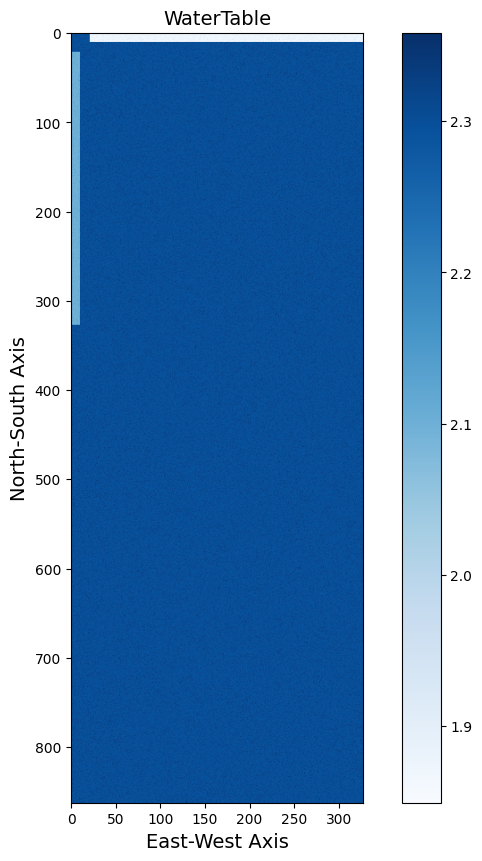

In [13]:
# plot the water level

def plot_water_table(timestep):
    #plot vegetation cover
    plt.figure(figsize=(10, 10))
    plt.imshow(W[:,:,timestep])

    plt.xlabel('East-West Axis', fontsize=14)
    plt.ylabel('North-South Axis', fontsize=14)
    plt.title('WaterTable', fontsize=14);
    plt.set_cmap("Blues")
    plt.colorbar()
    
    plt.show()
        
plot_water_table(3*24)